In [56]:
# Importing necessary libraries
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END
# from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage,HumanMessage
from langchain_core.runnables import RunnableConfig
from typing import TypedDict,List,Literal, Dict, Any
from typing_extensions import Annotated, Optional
from pydantic import BaseModel,Field
from dataclasses import dataclass, fields
from langchain.chat_models import init_chat_model
from tavily import AsyncTavilyClient
from enum import Enum
from langgraph.types import interrupt,Command
from langgraph.constants import Send
import asyncio
import operator
import uuid
from langgraph.checkpoint.memory import MemorySaver
load_dotenv()

True

In [57]:
# Loading the environment variables and model
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
llm = ChatGroq(model="gemma2-9b-it",temperature=0.3)

In [58]:
# Define the states and schema models
class UserRequirement(BaseModel):
    objective: str = Field(description="A brief statement outlining the primary goal or purpose of the application.")
    functional_requirements: str = Field(description="A detailed list of specific functionalities that the application must support to meet the user's needs.")
    non_functional_requirements: str = Field(description="A list of criteria that describe the quality attributes, performance, and constraints of the application.")

class RawRequirement(BaseModel):
    raw_requirement: UserRequirement

class UserStory(BaseModel):
    title: str = Field(description="Title of this user story")
    description: str = Field(description="Description of this user story")
    acceptance: str = Field(description="Acceptance criteria to mark this user story as aceepted")
    status: Literal["ToDo","Inprogess","Done"] = Field(description="Status of the user story, whether this user story is in Done, Inprogess or todo state")    

class UserStories(BaseModel):
    stories : List[UserStory] = Field(description="User Stories related to project")

# States
class WorkFlowInputState(TypedDict):
    raw_requirements: str

class WorkflowState(TypedDict):
    raw_requirements: str
    user_requirement: UserRequirement
    feedback_from_owner: str
    feedback_from_user: str
    stories : list[UserStory]
    completed_stories: Annotated[list,operator.add]



In [59]:
# prompts
DEFAULT_USER_REQUIREMENTS_STRUCTURE = """
Please provide your application requirements using the following structure:

1. Objective
  - Briefly describe the main goal or purpose of the application.

2. Functional Requirements
  - List the specific functionalities you want the application to have. For example:
    - Users should be able to create, view, update, and delete tasks.
    - The application should allow users to set priorities for tasks.
    - Users should be able to search and filter tasks.

3. Non-functional Requirements
  - Specify any performance, security, or usability criteria. For example:
    - The application should load and respond quickly.
    - User data should be securely stored and protected.
    - The interface should be intuitive and easy to navigate.
"""

user_requirements_instructions = """
I want a user requirements that is concise and focused.

<User Requirement>
The raw requirements provided by user
{user_requirements}
</User Requirement>

<Requirement organization>
The requirement should follow the below requirement structure
{requirement_organization}
</Requirement organization>


<Task>
Generate a structural user requirements using the provided raw user requirement.

For example, a good user requirement structure might look like:
1/ objective
2/ functional requirements
3/ non functional requirements

Before returning the user requirements, go through the each section of user requirments and mention if anything is missing
</Task>

<Feedback>
Here is feedback on the user requirement structure from review (if any):
{feedback}
</Feedback>

<Format>
Call the UserRequirement tool 
</Format>

<Instructions>
If any field in the raw requirements is unclear, please generate it yourself, ensure the generation follow the mention requirement_organization structure.
</Instructions>
"""

##### Refine the user requirements

In [75]:
def refine_user_requirments(state:WorkflowState):
    raw_requirements = state["raw_requirements"]
    requirement_organization = DEFAULT_USER_REQUIREMENTS_STRUCTURE
    feedback_from_user = state.get("feedback_from_user",None)
    Requirement_Planner = ChatGroq(model="gemma2-9b-it",temperature=0.3).with_structured_output(RawRequirement)
    system_instructions = user_requirements_instructions.format(user_requirements=raw_requirements,requirement_organization=requirement_organization,feedback=feedback_from_user)
    requirement_result = Requirement_Planner.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate the user requirements as per organization given structure from the raw user requirements.")])
    print(requirement_result.raw_requirement.objective)
    return {"user_requirement":requirement_result.raw_requirement}

##### User requirement feedback

In [76]:
def human_feedback_user_requirments(state:WorkflowState):
    user_req = state["user_requirement"]

    interrupt_message = f"""Please provide the feedback for the below user requirements.
                        \n\n{user_req}\n
                        \nDoes the user requirements meet your needs?\nPass 'true' to approve the user requirements.\nOr, provide feedback to regenerate the user requirements:"""
    
    feedback = interrupt(value=interrupt_message)
    
    if isinstance(feedback, bool) and feedback is True:
        print("into the feedback boolean")
        return Command(goto="dummy_node")
    
    elif isinstance(feedback, str):
        print("into the feedback string")
        return Command(goto="refine_user_requirements", update={"feedback_from_user": feedback})
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")

##### Dummy node

In [77]:
def dummy_node(state:WorkflowState):
    print("into the dummy node")

##### Build the Workflow

In [78]:
graph = StateGraph(state_schema=WorkflowState,input=WorkFlowInputState)
graph.add_node("refine_user_requirements",refine_user_requirments)
graph.add_node("human_feedback_user_requirments",human_feedback_user_requirments)
graph.add_node("dummy_node",dummy_node)
graph.add_edge(START,"refine_user_requirements")
graph.add_edge("refine_user_requirements","human_feedback_user_requirments")
graph.add_edge("human_feedback_user_requirments","dummy_node")
graph.add_edge("dummy_node",END)
Workflow = graph.compile(checkpointer=MemorySaver())

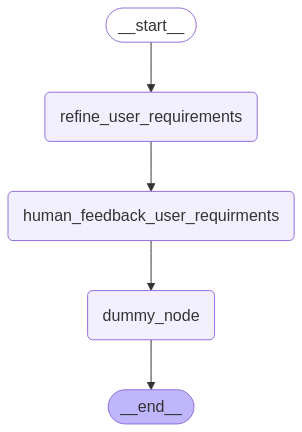

In [79]:
Workflow

In [80]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

In [81]:
raw_requirements = """Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. 
Users should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.The application should have a simple and intuitive user interface."""
for event in Workflow.stream(input={"raw_requirements":raw_requirements},stream_mode="updates",config=config):
    if "__interrupt__" in event:
        print(event["__interrupt__"][0].value)

Users should be able to manage their tasks effectively.
Please provide the feedback for the below user requirements.
                        

objective='Users should be able to manage their tasks effectively.' functional_requirements='Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed.' non_functional_requirements='The application should have a simple and intuitive user interface.'

                        
Does the user requirements meet your needs?
Pass 'true' to approve the user requirements.
Or, provide feedback to regenerate the user requirements:


In [67]:
for event in Workflow.stream(Command(resume="The application should have CRUD operations"),config=config,stream_mode="updates"):
    print(event)

into the feedback string
{'human_feedback_user_requirments': {'feedback_from_user': 'The application should have CRUD operations'}}
into the dummy node
raw_requirement=UserRequirement(objective=' ', functional_requirements='Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. Users should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.', non_functional_requirements='The application should have a simple and intuitive user interface.')
{'dummy_node': None}
{'refine_user_requirements': {'user_requirement': RawRequirement(raw_requirement=UserRequirement(objective=' ', functional_requirements='Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. Users should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.', non_functional_requirements='The application should have a simple and intuit